<a href="https://colab.research.google.com/github/ricardoV94/ThinkBayesPymc3/blob/master/ThinkBayes_Chapter_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
pip install arviz

In [0]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

## 7.1 The Boston Bruins problem

/usr/local/lib/python3.6/dist-packages/pymc3/distributions/continuous.py:88: UserWarning: The variable specified for lam has negative support for Exponential, likely making it unsuitable for this parameter.
  warnings.warn(msg)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [time_between_goals, goal_avg]
100%|██████████| 2500/2500 [00:02<00:00, 1015.89it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


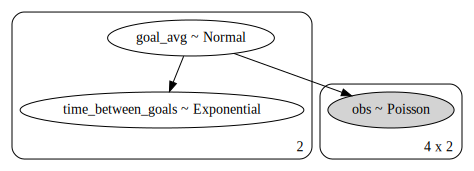

In [3]:
with pm.Model() as m_7_1:
    goal_avg = pm.Normal('goal_avg', mu=2.8, sigma=0.3, shape=2)
    obs = pm.Poisson('obs', mu=goal_avg, observed=np.array([[0,2,8,4], [1,3,1,0]]).T)
    time_between_goals = pm.Exponential('time_between_goals', lam=goal_avg, shape=2)

    trace_m_7_1 = pm.sample(2000)
pm.model_to_graphviz(m_7_1)

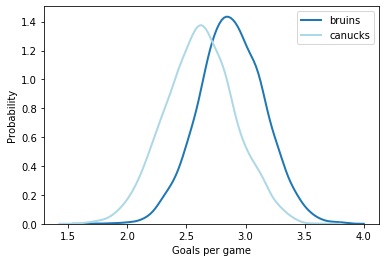

In [4]:
sns.distplot(trace_m_7_1['goal_avg'][:, 0], label='bruins', hist=False, kde_kws={'lw':2})
sns.distplot(trace_m_7_1['goal_avg'][:, 1], label='canucks', color='lightblue', hist=False, kde_kws={'lw':2})
plt.xlabel('Goals per game')
plt.ylabel('Probability');

In [5]:
trace_m_7_1['goal_avg'].mean(0)

array([2.87996478, 2.61464651])

## 7.4 The distribution of goals

In [6]:
ppc = pm.sample_posterior_predictive(trace_m_7_1, model=m_7_1, samples=2000)

100%|██████████| 2000/2000 [00:00<00:00, 2413.73it/s]


In [0]:
goal_bruins = ppc['obs'][:, :, 0].reshape(-1)
goal_canucks = ppc['obs'][:, :, 1].reshape(-1)

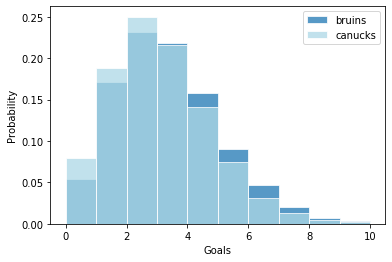

In [8]:
plt.hist(goal_bruins, density=True, ec='w', bins=np.linspace(0,10,11), alpha=.75, label='bruins')
plt.hist(goal_canucks, density=True, ec='w', bins=np.linspace(0,10,11), color='lightblue', alpha=.75, label='canucks')
plt.legend()
plt.xlabel('Goals')
plt.ylabel('Probability');

## 7.5 The probability of winning

In [0]:
goal_diff = goal_bruins - goal_canucks

In [10]:
f'p_win = {np.mean(goal_diff > 0)*100:.0f}%, p_loss = {np.mean(goal_diff < 0)*100:.0f}%, p_tie = {np.mean(goal_diff == 0)*100:.0f}%'

'p_win = 46%, p_loss = 37%, p_tie = 17%'

## 7.6 Sudden death

In [0]:
time_goal_bruins = trace_m_7_1['time_between_goals'][:, 0]
time_goal_canucks = trace_m_7_1['time_between_goals'][:, 1]

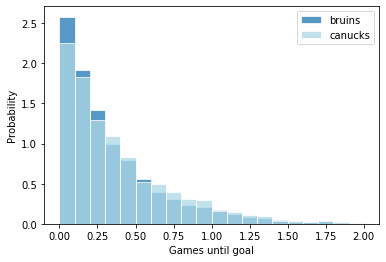

In [12]:
plt.hist(time_goal_bruins, density=True, ec='w', bins=np.linspace(0,2,21), alpha=.75, label='bruins')
plt.hist(time_goal_canucks, density=True, ec='w', bins=np.linspace(0,2,21), color='lightblue', alpha=.75, label='canucks')
plt.legend()
plt.xlabel('Games until goal')
plt.ylabel('Probability');

In [0]:
time_goal_diff = time_goal_bruins - time_goal_canucks

In [14]:
f'p_win_overtime = {np.mean(time_goal_diff < 0)*100:.0f}%'

'p_win_overtime = 53%'

In [15]:
p_win = np.mean(goal_diff > 0) + np.mean(goal_diff==0) * np.mean(time_goal_diff < 0)
f'p_win = {p_win*100:.0f}%'

'p_win = 55%'

In [16]:
p_win_series = (p_win**2) + (2 * p_win * (1-p_win) * p_win)
f'p_win_series = {p_win_series*100:.0f}%'

'p_win_series = 58%'

## 7.7 Discussion 
Changing the prior std from .3 to .85

In [17]:
with pm.Model() as m_7_7:
    goal_avg = pm.Normal('goal_avg', mu=2.8, sigma=0.85, shape=2)
    obs = pm.Poisson('obs', mu=goal_avg, observed=np.array([[0,2,8,4], [1,3,1,0]]).T)
    time_between_goals = pm.Exponential('time_between_goals', lam=goal_avg, shape=2)

    trace_m_7_7 = pm.sample(2000)

/usr/local/lib/python3.6/dist-packages/pymc3/distributions/continuous.py:88: UserWarning: The variable specified for lam has negative support for Exponential, likely making it unsuitable for this parameter.
  warnings.warn(msg)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [time_between_goals, goal_avg]
100%|██████████| 2500/2500 [00:02<00:00, 1077.02it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
ppc_m_7_7 = pm.sample_posterior_predictive(trace_m_7_7, model=m_7_7, samples=2000)

100%|██████████| 2000/2000 [00:00<00:00, 2337.40it/s]


In [19]:
goal_bruins = ppc_m_7_7['obs'][:, :, 0].reshape(-1)
goal_canucks = ppc_m_7_7['obs'][:, :, 1].reshape(-1)
goal_diff = goal_bruins - goal_canucks

time_goal_bruins = trace_m_7_7['time_between_goals'][:, 0]
time_goal_canucks = trace_m_7_7['time_between_goals'][:, 1]
time_goal_diff = time_goal_bruins - time_goal_canucks

p_win = np.mean(goal_diff > 0) + np.mean(goal_diff==0) * np.mean(time_goal_diff < 0)
p_win_series = (p_win**2) + (2 * p_win * (1-p_win) * p_win)
f'p_win_series = {p_win_series*100:.0f}%'

'p_win_series = 81%'